PART 1: REGRESSION (CALIFORNIA HOUSING)
Attempt 1 failed to download California Housing dataset: HTTP Error 403: Forbidden. Retrying in 5 seconds...
Attempt 2 failed to download California Housing dataset: HTTP Error 403: Forbidden. Retrying in 5 seconds...
Failed to download California Housing dataset after 3 attempts: HTTP Error 403: Forbidden.
Please check your internet connection or try again later. You might also need to manually download the dataset if the issue persists.
Skipping Regression (California Housing) analysis due to data download failure.

PART 2: CLASSIFICATION (BREAST CANCER)
Train: (455, 30), Test: (114, 30)

Step 1: Baseline


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Train: 0.9868
Accuracy Test:  0.9825

Step 2: Hyperparameter Tuning
Best params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.9825

Step 3: L1 vs L2 Regularization

L1 - Train: 0.9890, Test: 0.9825
L2 - Train: 0.9692, Test: 0.9561
L1 zero coefficients: 8/30


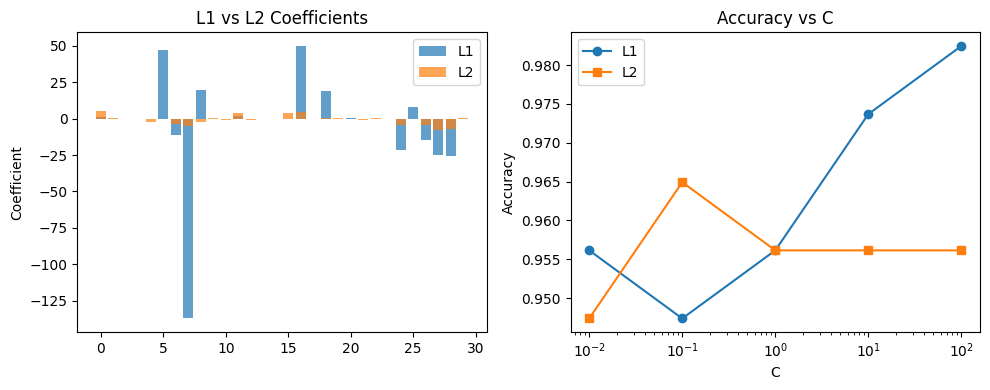

In [3]:
# Import libraries
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from urllib.error import HTTPError
import time

print("PART 1: REGRESSION (CALIFORNIA HOUSING)")

# Load and split data
n_retries = 3
delay = 5  # seconds
housing_data_loaded = False # Flag to check if data was loaded
for i in range(n_retries):
    try:
        X, y = fetch_california_housing(return_X_y=True, as_frame=True, n_retries=10, delay=1)
        print("California Housing dataset loaded successfully.")
        housing_data_loaded = True
        break
    except HTTPError as e:
        if i < n_retries - 1:
            print(f"Attempt {i+1} failed to download California Housing dataset: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
        else:
            print(f"Failed to download California Housing dataset after {n_retries} attempts: {e}.")
            print("Please check your internet connection or try again later. You might also need to manually download the dataset if the issue persists.")
            # Do not exit, just mark that data was not loaded

if housing_data_loaded: # Only proceed with regression if data was loaded
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")

    # Step 1: Baseline Model
    print("\nStep 1: Baseline (No Regularization)")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(f"MSE Train: {mean_squared_error(y_train, lr.predict(X_train)):.4f}")
    print(f"MSE Test:  {mean_squared_error(y_test, lr.predict(X_test)):.4f}")

    # Step 2: Hyperparameter Tuning
    print("\nStep 2: Hyperparameter Tuning")
    alpha_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

    ridge_cv = GridSearchCV(Ridge(), alpha_grid, cv=5, scoring='neg_mean_squared_error')
    ridge_cv.fit(X_train, y_train)
    print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")

    lasso_cv = GridSearchCV(Lasso(max_iter=10000), alpha_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_cv.fit(X_train, y_train)
    print(f"Best Lasso alpha: {lasso_cv.best_params_['alpha']}")

    # Step 3: L1 vs L2 Comparison
    print("\nStep 3: L1 vs L2 Regularization")
    ridge = Ridge(alpha=ridge_cv.best_params_['alpha'])
    ridge.fit(X_train, y_train)
    lasso = Lasso(alpha=lasso_cv.best_params_['alpha'], max_iter=10000)
    lasso.fit(X_train, y_train)

    print(f"\nRidge - Train: {mean_squared_error(y_train, ridge.predict(X_train)):.4f}, Test: {mean_squared_error(y_test, ridge.predict(X_test)):.4f}")
    print(f"Lasso - Train: {mean_squared_error(y_train, lasso.predict(X_train)):.4f}, Test: {mean_squared_error(y_test, lasso.predict(X_test)):.4f}")
    print(f"Lasso zero coefficients: {np.sum(np.abs(lasso.coef_) < 1e-10)}/{len(lasso.coef_)}")

    # Visualization
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(lr.coef_, 'o', label='Linear')
    plt.plot(ridge.coef_, 'x', label='Ridge')
    plt.plot(lasso.coef_, 's', label='Lasso')
    plt.ylabel('Coefficient')
    plt.title('Coefficient Comparison')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    alphas = [0.01, 0.1, 1, 10, 100]
    ridge_mse = [mean_squared_error(y_test, Ridge(alpha=a).fit(X_train, y_train).predict(X_test)) for a in alphas]
    lasso_mse = [mean_squared_error(y_test, Lasso(alpha=a, max_iter=10000).fit(X_train, y_train).predict(X_test)) for a in alphas]
    plt.plot(alphas, ridge_mse, 'o-', label='Ridge')
    plt.plot(alphas, lasso_mse, 's-', label='Lasso')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.title('MSE vs Alpha')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Regression (California Housing) analysis due to data download failure.")

print("PART 2: CLASSIFICATION (BREAST CANCER)")

# Load and split data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Step 1: Baseline Model
print("\nStep 1: Baseline")
lr = LogisticRegression(max_iter=10000, C=1e10)
lr.fit(X_train, y_train)
print(f"Accuracy Train: {accuracy_score(y_train, lr.predict(X_train)):.4f}")
print(f"Accuracy Test:  {accuracy_score(y_test, lr.predict(X_test)):.4f}")

# Step 2: Hyperparameter Tuning
print("\nStep 2: Hyperparameter Tuning")
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print(f"Best params: {grid.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, grid.predict(X_test)):.4f}")

# Step 3: L1 vs L2 Comparison
print("\nStep 3: L1 vs L2 Regularization")
best_C = grid.best_params_['C']

l1 = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=10000)
l1.fit(X_train, y_train)
l2 = LogisticRegression(penalty='l2', C=best_C, solver='liblinear', max_iter=10000)
l2.fit(X_train, y_train)

print(f"\nL1 - Train: {accuracy_score(y_train, l1.predict(X_train)):.4f}, Test: {accuracy_score(y_test, l1.predict(X_test)):.4f}")
print(f"L2 - Train: {accuracy_score(y_train, l2.predict(X_train)):.4f}, Test: {accuracy_score(y_test, l2.predict(X_test)):.4f}")
print(f"L1 zero coefficients: {np.sum(np.abs(l1.coef_[0]) < 1e-10)}/{len(l1.coef_[0])}")

# Visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(l1.coef_[0])), l1.coef_[0], alpha=0.7, label='L1')
plt.bar(range(len(l2.coef_[0])), l2.coef_[0], alpha=0.7, label='L2')
plt.ylabel('Coefficient')
plt.title('L1 vs L2 Coefficients')
plt.legend()

plt.subplot(1, 2, 2)
C_vals = [0.01, 0.1, 1, 10, 100]
l1_acc = [accuracy_score(y_test, LogisticRegression(penalty='l1', C=c, solver='liblinear', max_iter=10000).fit(X_train, y_train).predict(X_test)) for c in C_vals]
l2_acc = [accuracy_score(y_test, LogisticRegression(penalty='l2', C=c, solver='liblinear', max_iter=10000).fit(X_train, y_train).predict(X_test)) for c in C_vals]
plt.plot(C_vals, l1_acc, 'o-', label='L1')
plt.plot(C_vals, l2_acc, 's-', label='L2')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C')
plt.legend()
plt.tight_layout()
plt.show()

